# Improving Graph

We will improve our graph by:
1. Defining clear edge weights (and later node size)
2. Using better visualizations using Plotly which is interactive

In [1]:
import networkx as nx
import json

import math
import statistics
from sklearn import preprocessing # to normalize

from collections import Counter, defaultdict, OrderedDict

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

## Reading Data

In [124]:
# ns_subreddit
with open("ns_subreddit_2021-01.json") as infile1:
    ns_subreddit_01 = json.load(infile1)
    
with open("ns_subreddit_2021-02.json") as infile2:
    ns_subreddit_02 = json.load(infile2)
    
with open("ns_subreddit_2021-03.json") as infile3:
    ns_subreddit_03 = json.load(infile3)
    
with open("ns_subreddit_2021-04.json") as infile4:
    ns_subreddit_04 = json.load(infile4)
    
with open("ns_subreddit_2021-05.json") as infile5:
    ns_subreddit_05 = json.load(infile5)
    
with open("ns_subreddit_2021-06.json") as infile6:
    ns_subreddit_06 = json.load(infile6)
   
# subreddit_ns
with open("subreddit_ns_2021-01.json") as infile1a:
    subreddit_ns_01 = json.load(infile1a)
    
with open("subreddit_ns_2021-02.json") as infile2a:
    subreddit_ns_02 = json.load(infile2a)
    
with open("subreddit_ns_2021-03.json") as infile3a:
    subreddit_ns_03 = json.load(infile3a)
    
with open("subreddit_ns_2021-04.json") as infile4a:
    subreddit_ns_04 = json.load(infile4a)
    
with open("subreddit_ns_2021-05.json") as infile5a:
    subreddit_ns_05 = json.load(infile5a)
    
with open("subreddit_ns_2021-06.json") as infile6a:
    subreddit_ns_06 = json.load(infile6a)

Let's define our `news_sources` and `subreddits`.

In [125]:
news_sources = list(set(ns_subreddit_01.keys()) & 
                    set(ns_subreddit_02.keys()) & 
                    set(ns_subreddit_03.keys()) & 
                    set(ns_subreddit_04.keys()) & 
                    set(ns_subreddit_05.keys()) & 
                    set(ns_subreddit_06.keys()))
len(news_sources)

2687

In [126]:
subreddits = list(set(subreddit_ns_01.keys()) &
                  set(subreddit_ns_02.keys()) &
                 set(subreddit_ns_03.keys()) &
                 set(subreddit_ns_04.keys()) &
                 set(subreddit_ns_05.keys()) &
                 set(subreddit_ns_06.keys()))
len(subreddits)

5699

Let's only use subreddits with the most subscribers

In [127]:
# Let's only use the subreddits that have lots of subscribers
with open ("subreddit_subscribers.json", "r", encoding = "utf-8") as infile:
    subreddit_subscribers = json.load(infile)

In [128]:
subreddits_w_subc = [subreddits[k] for k in range(len(subreddits)) if subreddits[k] in subreddit_subscribers]
len(subreddits_w_subc)

5238

Out of our 5.7k subreddits, we only have subscribers data for 5.2k of them. Let's drop the descriptions with `None` values.

In [129]:
subreddits_w_subc = [s for s in subreddits_w_subc if subreddit_subscribers[s] is not None]
len(subreddits_w_subc)

5236

In [130]:
srs_all = sorted(subreddits_w_subc, key= lambda x: subreddit_subscribers[x], reverse= True)

In [131]:
# example number of subsribers
[(s,subreddit_subscribers[s]) for s in srs_all[:10] if subreddit_subscribers[s] > 0]

[('funny', 31060166),
 ('gaming', 26628444),
 ('aww', 25197817),
 ('pics', 24911449),
 ('science', 24268001),
 ('worldnews', 24253881),
 ('Music', 24041486),
 ('videos', 23114010),
 ('movies', 23087255),
 ('todayilearned', 23030716)]

Text(0.5, 1.0, 'All Subreddit Subscribers')

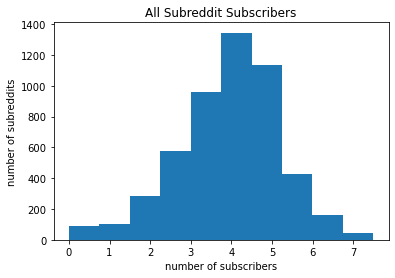

In [132]:
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])

plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all if subreddit_subscribers[s] > 0])
plt.xlabel("number of subscribers")
plt.ylabel("number of subreddits")
plt.title("All Subreddit Subscribers")

# could log scale for both x and y

In [133]:
len([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])

5118

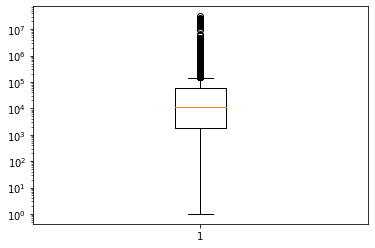

In [134]:
plt.boxplot([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])
plt.yscale("log")

Text(0.5, 1.0, 'Top 1k Subreddit Subscribers')

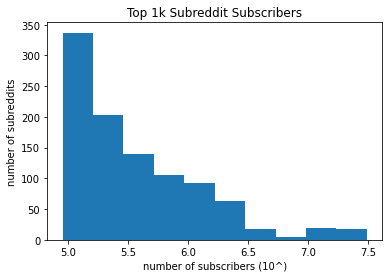

In [135]:
# plt.hist([subreddit_subscribers[s] for s in srs_all if subreddit_subscribers[s] > 0])

plt.close()
# plt.yscale("log")
plt.hist([math.log(subreddit_subscribers[s],10) for s in srs_all[:1000] if subreddit_subscribers[s] > 0])
plt.xlabel("number of subscribers (10^)")
plt.ylabel("number of subreddits")
plt.title("Top 1k Subreddit Subscribers")

# could log scale for both x and y

In [136]:
# srs_1000 = srs_all[:1000]
srs_1000 = srs_all[:200] # using 1000 subreddits yields in very condensed graph.

## Edges and Nodes

As edge weight, we use the formula

(min/max) * ((min+max)/2)

In [137]:
subreddit_files = [subreddit_ns_01, subreddit_ns_02, subreddit_ns_03, subreddit_ns_04, subreddit_ns_05, subreddit_ns_06]

First we calculate the strength of relationship between two nodes, based on each of the number of their occurences in each subreddit they co-occur in.

In [138]:
# co_occurences = defaultdict(int)
per_subreddits = defaultdict(list)
node_sizes = defaultdict(int)

for subreddit_file in subreddit_files:
    for s in subreddit_file:
        # we will only process for this subreddit if it is one of the 1k subreddits with the most subscribers
        if s not in srs_1000:
            continue
        # each s contains news sources and how many times they appear
        news_sources1 = list(subreddit_file[s].keys())
        # make pairings
        i = 0
        while i < len(news_sources1)-1:
            # record node details for this particular news source
            node_sizes[news_sources1[i]] += 1
            j = i + 1
            while j <= len(news_sources1)-1:
                ns_pair = sorted([news_sources1[i], news_sources1[j]])
                # cast to be tuple after sorting in alphabetical pair
                ns_pair = tuple(ns_pair)
                n1, n2 = ns_pair
                # the pairing co_occur in this subreddit
                # co_occurences[ns_pair] += 1 # old
                # let's find the min and max subscribers
                s1 = subreddit_file[s][n1]
                s2 = subreddit_file[s][n2]
                maxx = max(s1,s2)
                minn = min(s1,s2)
                # then calculate the weight for this one 
                weight = (minn/maxx)*((minn+maxx)/2)
                per_subreddits[ns_pair].append(weight)
                j += 1
            i += 1
        # increment for the last news source
        node_sizes[news_sources1[-1]] += 1

In [139]:
per_subreddits[('imdb.com', 'nytimes.com')]

[0.50187265917603,
 9.041666666666668,
 0.5208333333333333,
 1.3333333333333333,
 23.211267605633804,
 3.333333333333333,
 9.272727272727272,
 1.4000000000000001,
 4.955056179775281,
 0.6000000000000001,
 1.0206185567010309,
 0.625,
 1.0,
 0.75,
 2.4,
 0.75,
 0.6666666666666666,
 0.525,
 1.0,
 1.0,
 2.25,
 0.75,
 0.75,
 1.0,
 0.75,
 3.5806451612903225,
 1.0040080160320641,
 0.55,
 1.025974025974026,
 27.876712328767123,
 3.888888888888889,
 2.4,
 16.043478260869566,
 11.176470588235293,
 0.5333333333333333,
 1.0,
 1.0333333333333332,
 2.4,
 0.6000000000000001,
 0.75,
 1.037037037037037,
 0.55,
 0.5384615384615385,
 15.11111111111111,
 2.530940594059406,
 37.66025641025641,
 2.2758620689655173,
 0.5625,
 0.5121951219512195,
 1.0350877192982455,
 11.7,
 0.5094339622641509,
 24.890625,
 0.5454545454545454,
 5.7272727272727275,
 3.8888888888888893,
 0.75,
 1.0,
 1.0,
 0.5714285714285714,
 2.0,
 0.625,
 0.75,
 0.75,
 20.426229508196723,
 0.5011494252873563,
 9.177777777777777,
 2.1269841269

Let's only consider pairings that co-occur at least 10 times.

In [140]:
per_subreddits_10 = {p: per_subreddits[p] for p in per_subreddits if len(per_subreddits[p]) >= 10}

In [141]:
len(per_subreddits)

1625825

In [142]:
len(per_subreddits_10)

177108

Then, we take an average of the strengths and set the edge weight to be this. I could also use the maximum value. Should I?

In [143]:
weights = defaultdict(int)

for pair in per_subreddits_10:
    weights[pair] = statistics.mean(per_subreddits[pair])

In [144]:
weights[('imdb.com', 'nytimes.com')]

3.965886210782035

In [145]:
len(weights)

177108

Now (I think) we are ready to build our graph!

## Preparing for Building a Graph

In [146]:
G = nx.Graph()
for e, w in list(weights.items()):
    u, v = e
    G.add_edge(u, v, weight=w)

In [147]:
# sanity check
'nytimes.com' in G.nodes()

True

In [148]:
len(G.nodes())

1093

In [149]:
len(G.edges())

177108

Let's first visualize the node sizes and edge weights.

Text(0.5, 1.0, 'Node Sizes')

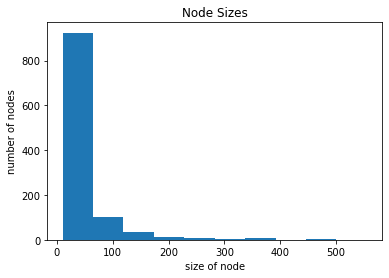

In [150]:
# Node Size
plt.close()
plt.hist([node_sizes[n] for n in G.nodes()])
# plt.yscale("log")
plt.ylabel("number of nodes")
plt.xlabel("size of node")
plt.title("Node Sizes")

Text(0.5, 1.0, 'Edge Weights')

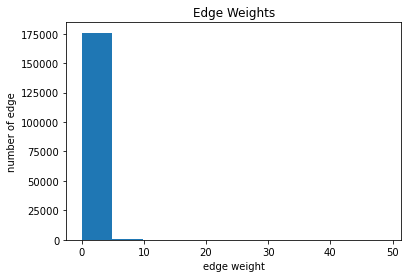

In [151]:
# Edge Weight
plt.close()
# plt.hist([weights[n] for n in G.edges()])
plt.hist([weights[n] for n in G.edges()])
# plt.yscale("log")
plt.ylabel("number of edge")
plt.xlabel("edge weight")
plt.title("Edge Weights")

In [152]:
len(G.edges())

177108

#### Building baseline graph

In [153]:
# norm_weights = normalize(freeze_weights)[0].tolist()
min_max_scaler = preprocessing.MinMaxScaler()
baseline_norm_weights = min_max_scaler.fit_transform(np.array([[weights[n] for n in G.edges()]]).T).T[0]

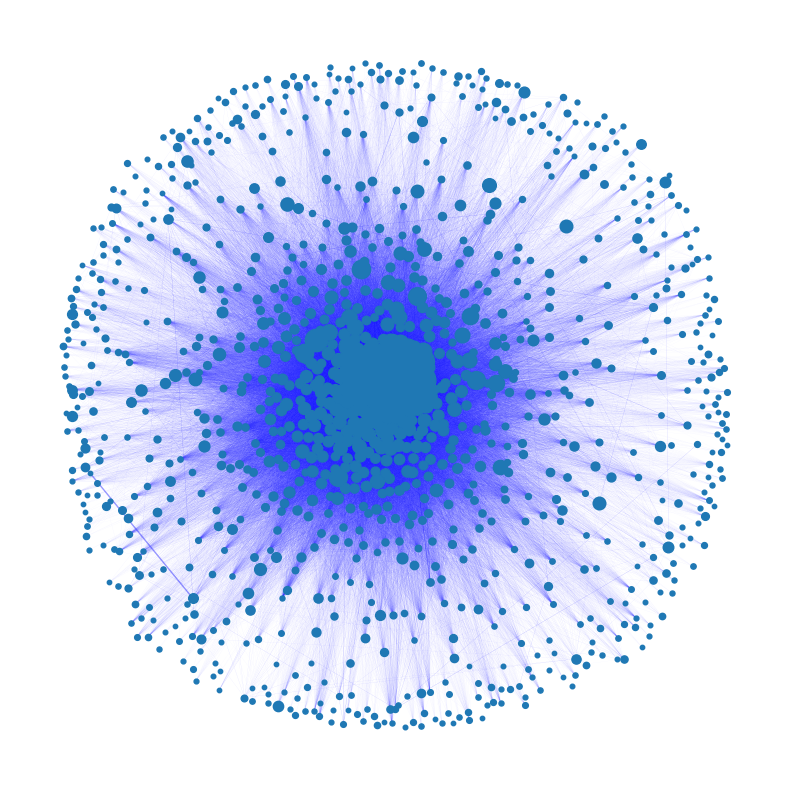

In [154]:
figure(figsize=(8, 8), dpi=100)
pos = nx.spring_layout(G, k=1.75, scale=None, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
for nn in G.nodes():
    # print("nn:", nn)
    nx.draw_networkx_nodes(G, pos, nodelist = [nn],
                           node_size=node_sizes[nn])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(G, pos, 
                       edgelist=G.edges,
                       width = [w for w in baseline_norm_weights],
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Using community detection using greedy modularity based algorithm

In [155]:
from networkx.algorithms.community import greedy_modularity_communities
G_karate = nx.karate_club_graph()
c = list(greedy_modularity_communities(G_karate))
print([len(com) for com in c])

[17, 9, 8]


In [156]:
c = list(greedy_modularity_communities(G))

In [157]:
len(c)

1

# Let's color based on clusters

In [158]:
with open('clusters_subscribers.json', 'r') as cluster_infile:
    clusters = json.load(cluster_infile)

In [159]:
for i in range(12):
    print(f"Cluster {i} is of length {len(clusters[str(i)])}")

Cluster 0 is of length 421
Cluster 1 is of length 133
Cluster 2 is of length 156
Cluster 3 is of length 839
Cluster 4 is of length 340
Cluster 5 is of length 44
Cluster 6 is of length 85
Cluster 7 is of length 134
Cluster 8 is of length 233
Cluster 9 is of length 183
Cluster 10 is of length 136
Cluster 11 is of length 81


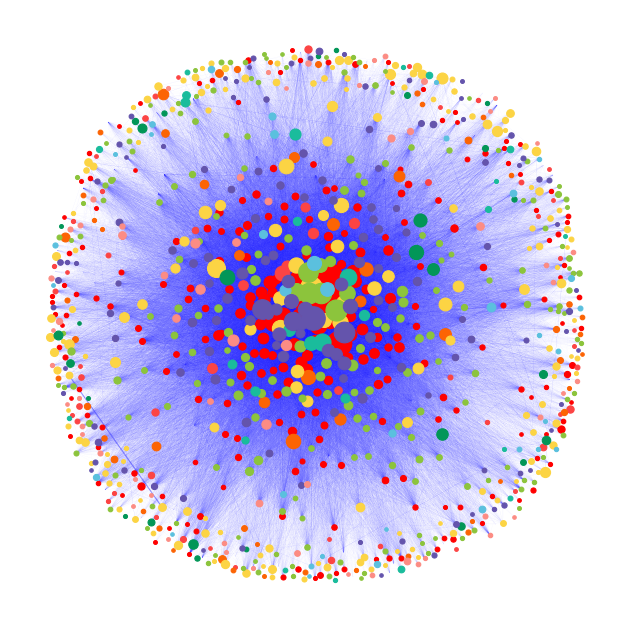

In [160]:
figure(figsize=(8, 8), dpi=80)
pos = nx.spring_layout(G, k=2.5, scale=None, seed=7)  # positions for all nodes - seed for reproducibility

colors = ["#ff0000", "#fc4444", "#fc6404", "#fcd444", "#8cc43c",
         "#029658", "#1abc9c", "#5bc0de", "#6454ac", "#fc8c84"]

# nodes
for i in range(10):
    for nn in clusters[str(i)]:
        if nn in G.nodes():
            nx.draw_networkx_nodes(G, pos, nodelist = [nn],
                               node_size=node_sizes[nn],
                              node_color = colors[i])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(G, pos, 
                       edgelist=G.edges,
                       width = [w for w in baseline_norm_weights],
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# *Questionable decision here*

In [315]:
# let's take out edges that are of weight <5
weights_filtered = {e:weights[e] for e in weights if weights[e] >= 3}

In [316]:
len(weights_filtered)

9596

Then, make new graph.

In [317]:
list(weights_filtered.items())[:5]

[(('cbssports.com', 'espn.com'), 7.080885357573302),
 (('247sports.com', 'espn.com'), 4.085351604484742),
 (('bleacherreport.com', 'espn.com'), 7.6819684138882485),
 (('espn.com', 'wmcactionnews5.com'), 3.1959932298278164),
 (('espn.com', 'theathletic.com'), 13.087474340328736)]

In [318]:
SG = nx.Graph()
# for e, w in list(list(weights_filtered.items())[:5]):
for e, w in list(weights_filtered.items()):
    u, v = e
    SG.add_edge(u, v, weight=w)

In [319]:
# check
'nytimes.com' in SG.nodes()

True

In [320]:
len(SG.edges)

9596

In [321]:
len(SG.nodes)

371

Let's freeze the ordering of the edges and their weights

In [322]:
# freeze_edges = list(weights_filtered.keys())
freeze_edges = list(SG.edges())

In [323]:
len(set([tuple(sorted(list(k))) for k in freeze_edges]) - set([tuple(sorted(list(l))) for l in SG.edges()]))

0

In [324]:
# freeze_weights = [weights_filtered[e] for e in freeze_edges]
freeze_weights = list()
for e in list(SG.edges()):
    if e in weights_filtered:
        freeze_weights.append(weights_filtered[e])
    else:
        freeze_weights.append(weights_filtered[(e[1],e[0])])

In [325]:
len(freeze_weights)

9596

Text(0.5, 1.0, 'Edge Weights')

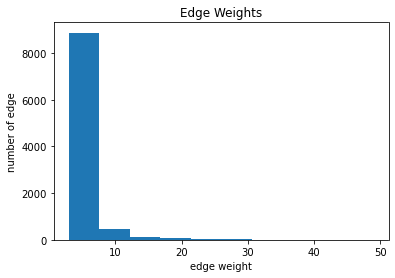

In [326]:
# Edge Weight
plt.close()
# plt.hist([weights[n] for n in G.edges()])
plt.hist([w for w in freeze_weights])
# plt.yscale("log")
plt.ylabel("number of edge")
plt.xlabel("edge weight")
plt.title("Edge Weights")

In [327]:
# norm_weights = normalize(freeze_weights)[0].tolist()
min_max_scaler = preprocessing.MinMaxScaler()
norm_weights = min_max_scaler.fit_transform(np.array([freeze_weights]).T).T[0]

(array([8.868e+03, 4.570e+02, 1.260e+02, 7.300e+01, 3.300e+01, 1.900e+01,
        1.100e+01, 6.000e+00, 2.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

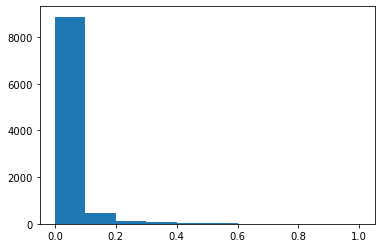

In [328]:
plt.hist(norm_weights)
# plt.yscale("log")

In [329]:
min(norm_weights)

0.0

In [330]:
max(norm_weights)

1.0

Let's multiply the weights by 5 so we get maximum weights of 5

In [331]:
norm_weights = [w*5 for w in norm_weights]

In [332]:
max(norm_weights)

5.0

(array([8.868e+03, 4.570e+02, 1.260e+02, 7.300e+01, 3.300e+01, 1.900e+01,
        1.100e+01, 6.000e+00, 2.000e+00, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

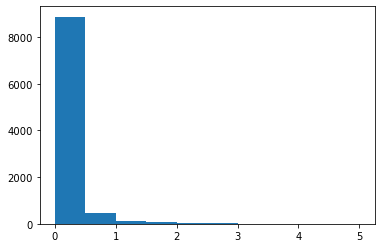

In [333]:
plt.hist(norm_weights)

In [334]:
type(SG.edges)

networkx.classes.reportviews.EdgeView

In [335]:
norm_edge_weights = {freeze_edges[i]:norm_weights[i] for i in range(len(norm_weights))}

In [336]:
ordered_weights = [norm_edge_weights[e] for e in SG.edges]

In [337]:
len(SG.edges())

9596

In [338]:
len(norm_edge_weights.keys())

9596

(array([8.868e+03, 4.570e+02, 1.260e+02, 7.300e+01, 3.300e+01, 1.900e+01,
        1.100e+01, 6.000e+00, 2.000e+00, 1.000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

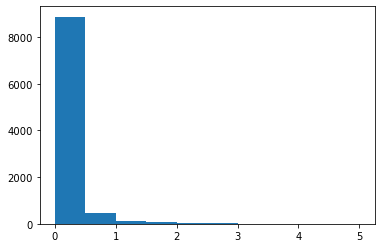

In [339]:
plt.hist(ordered_weights)

# Building a Graph

In [340]:
# ?nx.spring_layout

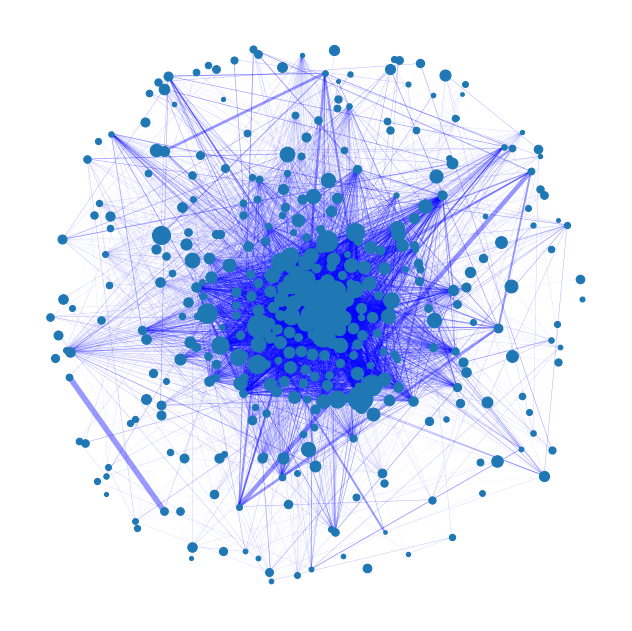

In [343]:
figure(figsize=(8, 8), dpi=80)
pos = nx.spring_layout(G, k=3, scale=None, seed=7)  # positions for all nodes - seed for reproducibility

# nodes
for nn in SG.nodes():
    # print("nn:", nn)
    nx.draw_networkx_nodes(SG, pos, nodelist = [nn],
                           node_size=node_sizes[nn])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(SG, pos, 
                       edgelist=SG.edges,
                       width = ordered_weights,
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Let's color based on clusters

In [344]:
with open('clusters_subscribers.json', 'r') as cluster_infile:
    clusters = json.load(cluster_infile)

In [345]:
for i in range(12):
    print(f"Cluster {i} is of length {len(clusters[str(i)])}")

Cluster 0 is of length 421
Cluster 1 is of length 133
Cluster 2 is of length 156
Cluster 3 is of length 839
Cluster 4 is of length 340
Cluster 5 is of length 44
Cluster 6 is of length 85
Cluster 7 is of length 134
Cluster 8 is of length 233
Cluster 9 is of length 183
Cluster 10 is of length 136
Cluster 11 is of length 81


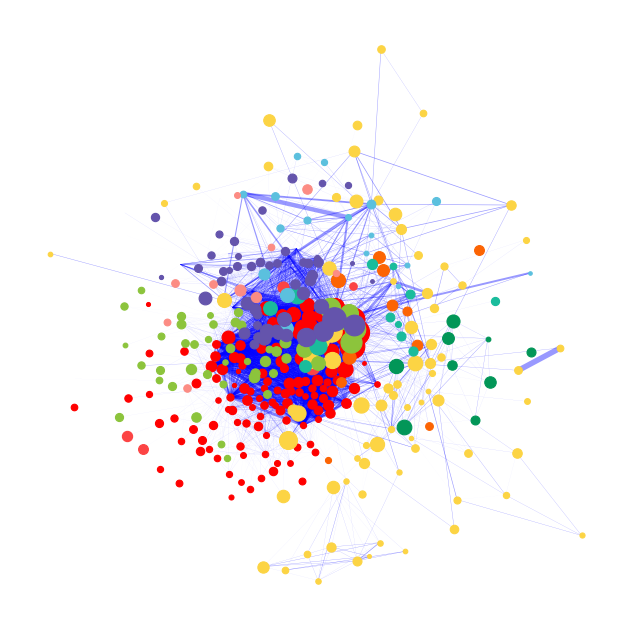

In [365]:
figure(figsize=(8, 8), dpi=80)
# pos = nx.spring_layout(SG, k=3, scale=None, seed=7)  # positions for all nodes - seed for reproducibility
pos = nx.kamada_kawai_layout(SG)  # positions for all nodes - seed for reproducibility

colors = ["#ff0000", "#fc4444", "#fc6404", "#fcd444", "#8cc43c",
         "#029658", "#1abc9c", "#5bc0de", "#6454ac", "#fc8c84"]

# nodes
for i in range(10):
    for nn in clusters[str(i)]:
        if nn in SG.nodes():
            nx.draw_networkx_nodes(SG, pos, nodelist = [nn],
                               node_size=node_sizes[nn],
                              node_color = colors[i])

# edges
# ecount = 0
# for u,v,w in G.edges(data=True):
#     if ecount%100 == 0:
#         print("{}% done".format(ecount*100/len_edges))
nx.draw_networkx_edges(SG, pos, 
                       edgelist=SG.edges,
                       width = ordered_weights,
                       alpha=0.4, edge_color="b")
#     ecount += 1

# # labels
# nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

# Using community detection using greedy modularity based algorithm

In [366]:
c = list(greedy_modularity_communities(SG))

In [367]:
[len(community) for community in c]

[353, 11, 7]

In [368]:
for ii in range(1,len(c)):
    print(f"In community {ii}")
    print(c[ii])

In community 1
frozenset({'hiphopdx.com', 'billboard.com', 'hotnewhiphop.com', 'complex.com', 'xxlmag.com', 'brooklynvegan.com', 'thesource.com', 'nme.com', 'allhiphop.com', 'pitchfork.com', 'stereogum.com'})
In community 2
frozenset({'motortrend.com', 'caranddriver.com', 'motor1.com', 'autoblog.com', 'jalopnik.com', 'roadandtrack.com', 'autocar.co.uk'})


# Trying out `plotly`

In [369]:
import plotly.graph_objects as go

In [370]:
SG_edgelist = list(SG.edges())

edge_x = []
edge_y = []


for edge in SG_edgelist:
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

In [371]:
link_sizes = [dict(SG.adjacency())[SG_edgelist[i][0]][SG_edgelist[i][1]]['weight'] for i in range(len(SG_edgelist))]

In [372]:
link_sizes[:10]

[7.080885357573302,
 3.874498453924393,
 9.05296452836022,
 7.533106188202126,
 8.859245118449442,
 3.0284722222222222,
 6.542527590694141,
 4.085351604484742,
 7.6819684138882485,
 3.1959932298278164]

In [373]:
SG_edgelist[:10]

[('cbssports.com', 'espn.com'),
 ('cbssports.com', '247sports.com'),
 ('cbssports.com', 'bleacherreport.com'),
 ('cbssports.com', 'theathletic.com'),
 ('cbssports.com', 'si.com'),
 ('cbssports.com', 'bild.de'),
 ('cbssports.com', 'theringer.com'),
 ('espn.com', '247sports.com'),
 ('espn.com', 'bleacherreport.com'),
 ('espn.com', 'wmcactionnews5.com')]

In [374]:
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.1, color='#888'),
    # line=dict(width=dict(G.adjacency())[SG_edgelist[i][0]][SG_edgelist[i][1]]['weight'], color='#888'),
    hoverinfo='none',
    mode='lines')

# make multiple traces
# traces={}
# for i in range(len(SG_edgelist)):
#     traces['trace_' + str(i)]=go.Scatter(x = (edge_x[i],), 
#                                            y = (edge_y[i],),
#                                            line=dict(
#                                                 color='#888',
#                                                 width=link_sizes[i]))
# edge_trace=list(traces.values())

In [375]:
node_x = []
node_y = []
for node in SG.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

In [376]:
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

In [377]:
node_adjacencies = []
node_text = []
for node, adjacencies in enumerate(SG.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(str(adjacencies[0])+'; '+str(len(adjacencies[1]))+' connections')

node_trace.marker.color = node_adjacencies
node_trace.text = node_text

In [378]:
# ?go.Figure

In [379]:
# edge_trace.append([node_trace])
fig = go.Figure(
             data=[edge_trace, node_trace],
             # data= edge_trace,
             layout=go.Layout(
                title='News Source Network based on Reddit',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    # text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

# Ego Graph

In [104]:
list(G.nodes())[:20]

['cbssports.com',
 'espn.com',
 'bleacherreport.com',
 'theathletic.com',
 'si.com',
 'chicagotribune.com',
 'seattletimes.com',
 'wmcactionnews5.com',
 'fivethirtyeight.com',
 'latimes.com',
 'yahoo.com',
 'independent.co.uk',
 'apnews.com',
 'animenewsnetwork.com',
 'crunchyroll.com',
 'imdb.com',
 'bloody-disgusting.com',
 'livescience.com',
 'deadline.com',
 'thewrap.com']

In [71]:
from networkx.generators import ego_graph

In [112]:
ego = ego_graph(G, "espn.com")

In [113]:
# dir(nx)

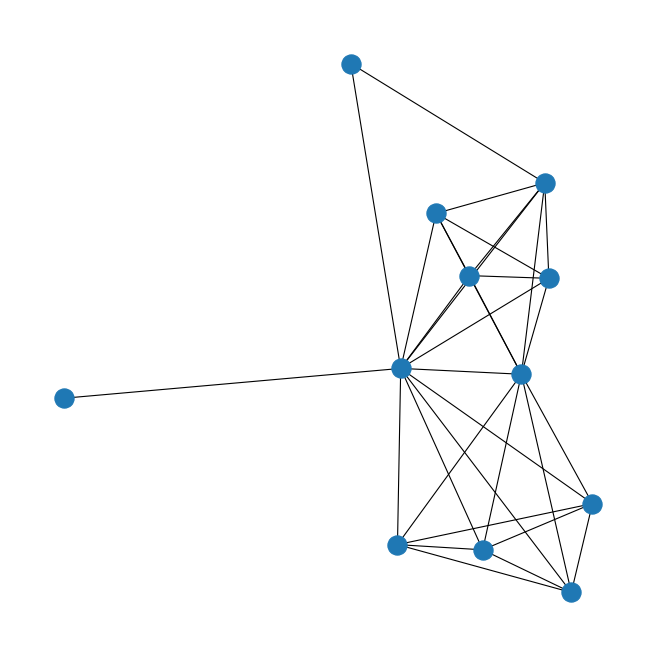

In [114]:
figure(figsize=(8, 8), dpi=80)
nx.draw_spring(ego)

# Trying `plotly`

In [67]:
!pip install plotly

In [68]:
import plotly.graph_objects as go

In [69]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

KeyError: 'pos'